# Requirements

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **close price** for the Amazon stock. To accomplish this, you will use data from the preceding 7 days, and past statistics. 


## The Amazon Stock Price Dataset

The dataset comprises the following columns:
- date - the date of the recorded price
- open - the open price of the stock
- high - the high price of the stock
- low - the low price of the stock
- volume - the volume trades
- close - the close price of the stock

Target:
close

Load the dataset into a `pandas` data frame.

In [105]:
data = pd.read_csv('amazon_stock_price.csv')

In [107]:
data.head()

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000


Explore the dataset using visualizations of your choice.

In [109]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685 entries, 0 to 6684
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6685 non-null   datetime64[ns]
 1   open    6685 non-null   float64       
 2   high    6685 non-null   float64       
 3   low     6685 non-null   float64       
 4   close   6685 non-null   float64       
 5   volume  6685 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 313.5 KB


In [111]:
def fill_data(data):
    data_copy = data.copy()
    data_copy.set_index('date', inplace=True)
    full_dates = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='D')
    data_copy = data_copy.reindex(full_dates)

    return data_copy

In [113]:
data = fill_data(data)
data.head()

,open,high,low,close,volume
1997-05-15,0.1219,0.1250,0.0964,0.0979,1.443120e+09
1997-05-16,0.0984,0.0990,0.0854,0.0865,2.940000e+08
1997-05-17,NaN,NaN,NaN,NaN,NaN
1997-05-18,NaN,NaN,NaN,NaN,NaN
1997-05-19,0.0880,0.0885,0.0812,0.0854,1.221360e+08


In [115]:
data = data.interpolate(limit_direction='both')
data.head()

,open,high,low,close,volume
1997-05-15,0.121900,0.1250,0.0964,0.097900,1.443120e+09
1997-05-16,0.098400,0.0990,0.0854,0.086500,2.940000e+08
1997-05-17,0.094933,0.0955,0.0840,0.086133,2.367120e+08
1997-05-18,0.091467,0.0920,0.0826,0.085767,1.794240e+08
1997-05-19,0.088000,0.0885,0.0812,0.085400,1.221360e+08


In [117]:
data['volume'] = data['volume'].apply(lambda x: int(x))
data.head()

,open,high,low,close,volume
1997-05-15,0.121900,0.1250,0.0964,0.097900,1443120000
1997-05-16,0.098400,0.0990,0.0854,0.086500,294000000
1997-05-17,0.094933,0.0955,0.0840,0.086133,236712000
1997-05-18,0.091467,0.0920,0.0826,0.085767,179424000
1997-05-19,0.088000,0.0885,0.0812,0.085400,122136000


In [119]:
data['date'] = data.index
data = data.reset_index(drop=True)
data.head()

,open,high,low,close,volume,date
0,0.121900,0.1250,0.0964,0.097900,1443120000,1997-05-15
1,0.098400,0.0990,0.0854,0.086500,294000000,1997-05-16
2,0.094933,0.0955,0.0840,0.086133,236712000,1997-05-17
3,0.091467,0.0920,0.0826,0.085767,179424000,1997-05-18
4,0.088000,0.0885,0.0812,0.085400,122136000,1997-05-19


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9702 entries, 0 to 9701
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   open    9702 non-null   float64       
 1   high    9702 non-null   float64       
 2   low     9702 non-null   float64       
 3   close   9702 non-null   float64       
 4   volume  9702 non-null   int64         
 5   date    9702 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 454.9 KB


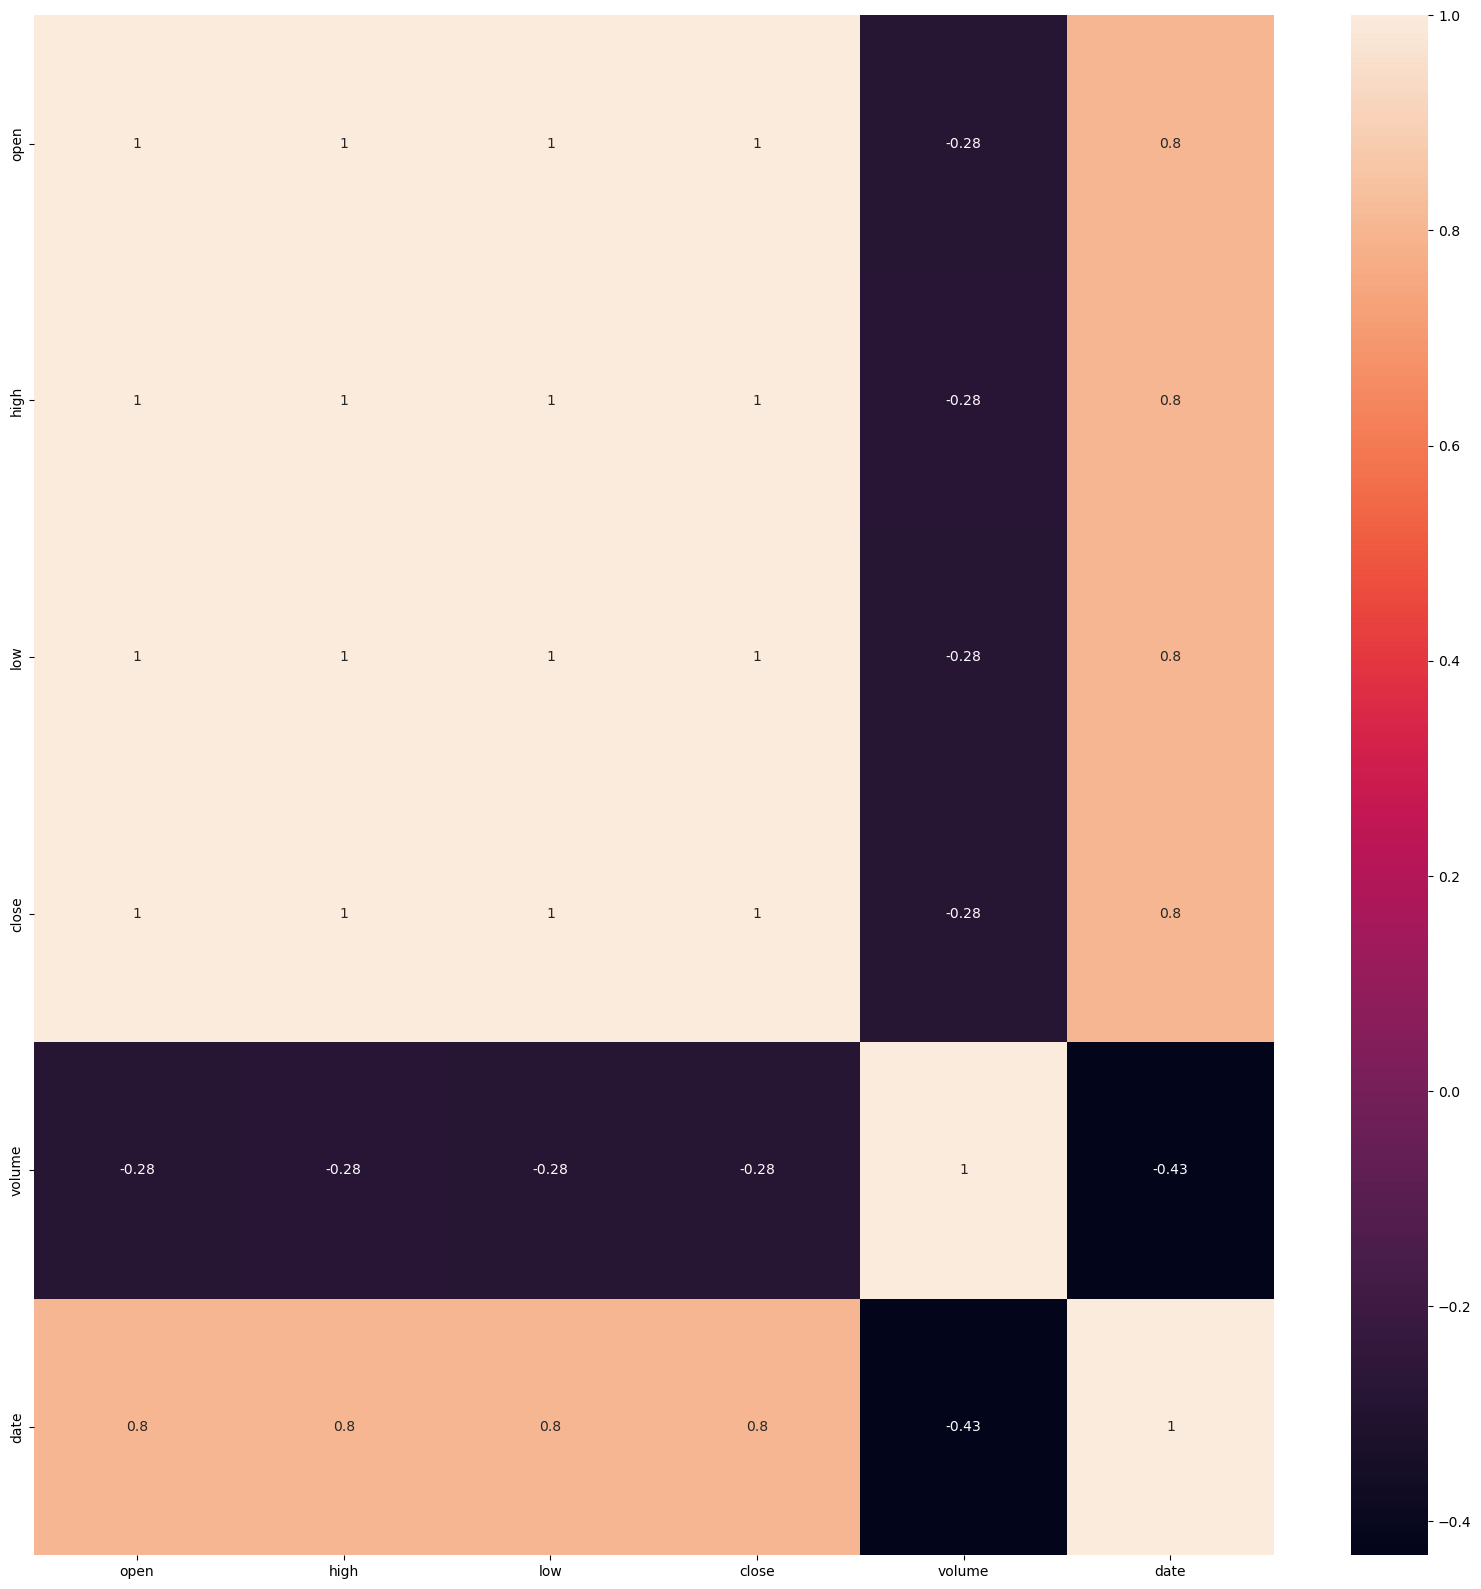

In [123]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True)
plt.show()

# Feauture Extraction
Select the relevant features for prediction and apply a lag of up to 7 days to each chosen feature

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [125]:
data = data.drop(columns=['open', 'high', 'low', 'volume', 'date'])
data.head()

,close
0,0.097900
1,0.086500
2,0.086133
3,0.085767
4,0.085400


In [127]:
features_to_lag = ['close']
lags = [1, 2, 3]

for feature in features_to_lag:
    for lag in lags:
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

In [129]:
data.head()

,close,close_lag1,close_lag2,close_lag3
0,0.097900,NaN,NaN,NaN
1,0.086500,0.097900,NaN,NaN
2,0.086133,0.086500,0.097900,NaN
3,0.085767,0.086133,0.086500,0.0979
4,0.085400,0.085767,0.086133,0.0865


In [131]:
data = data.dropna()
data.head()

,close,close_lag1,close_lag2,close_lag3
3,0.085767,0.086133,0.086500,0.097900
4,0.085400,0.085767,0.086133,0.086500
5,0.081800,0.085400,0.085767,0.086133
6,0.071400,0.081800,0.085400,0.085767
7,0.069800,0.071400,0.081800,0.085400


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [133]:
from sklearn.model_selection import train_test_split

data_new = data.drop('close',axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(data_new,  data['close'], test_size=0.2)

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [141]:
from xgboost import XGBRegressor

model = XGBRegressor(
    objective ='reg:linear',
    colsample_bytree = 0.3, 
    learning_rate = 0.1,
    max_depth = 5, alpha = 2, 
    n_estimators = 10
)
model.fit(X_train, Y_train)

C:\Users\ANA\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:26:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

Use the trained model to make predictions for the test set.

In [143]:
predictions = model.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [145]:
from sklearn.metrics import r2_score
print("R2-score :",r2_score(Y_test,predictions))

R2-score : 0.8753028386416326
